# Practical 5: Monte Carlo Methods

In [1]:
import numpy as np
import rldurham as rld

import matplotlib.pyplot as plt
from IPython import display as disp

Load an environment (start with the simple one and `is_slippery=False`).

In [2]:
# import the frozen lake gym environment
env = rld.make('FrozenLake-v1', is_slippery=False)
# env = rld.make('FrozenLake8x8-v1', is_slippery=False)
rld.seed_everything(42, env)

Seed set to 42


(42, 0, {'prob': 1})

Some variables for plotting

In [3]:
# plotting
ep_reward = 0
reward_list = [[]]
plot_data = [[]]
plot_labels = []
auc = [0]
experiment_id = 0

Play around with constant epsilon first, then move on to exploration schedules.

**What is the maximum AUC you can get on the 8x8 environment?**

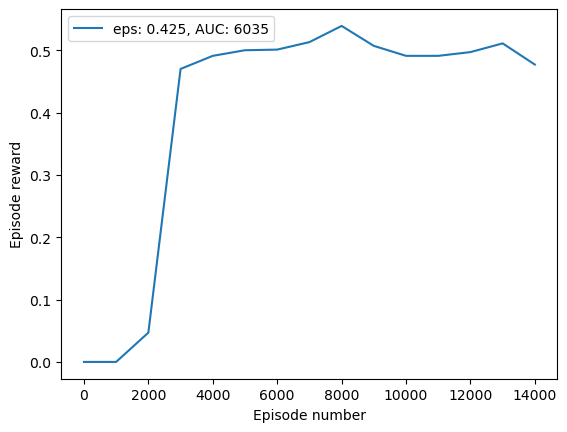

In [4]:
Q = np.zeros([env.observation_space.n, env.action_space.n])
n_s_a = np.zeros([env.observation_space.n, env.action_space.n])
num_episodes = 15000
epsilon = np.random.rand()*0.2+0.35 # change this each run
plot_labels.append("eps: {:.3f}".format(epsilon))

for episode in range(num_episodes):
    state, info = env.reset()
    done = False
    results_list = []
    result_sum = 0.0
    while not done:
        if np.random.rand() > epsilon:
            action = np.argmax(Q[state, :])
        else:
            action = env.action_space.sample()
        new_state, reward, term, trunc, info = env.step(action)
        done = term or trunc
        results_list.append((state, action))
        result_sum += reward
        state = new_state

    for (state, action) in results_list:
        n_s_a[state, action] += 1.0
        alpha = 1.0 / n_s_a[state, action]
        Q[state, action] += alpha * (result_sum - Q[state, action])

    reward_list[experiment_id].append(result_sum)
    auc[experiment_id] += int(result_sum)

    if episode % 1000 == 0:
        plot_data[experiment_id].append([episode, np.array(reward_list[experiment_id]).mean(),
            np.array(reward_list[experiment_id]).std()])
        reward_list[experiment_id] = []

        for i in range(len(plot_data)):
            plt.plot([x[0] for x in plot_data[i]], [x[1] for x in plot_data[i]],
                     '-', 
                     # color=colors[i], 
                     label=plot_labels[i] + ', AUC: '+str(auc[i]))
        plt.xlabel('Episode number')
        plt.ylabel('Episode reward')
        plt.legend()
        disp.clear_output(wait=True)
        plt.show()

# advance to next experiment (so when we run the cell again we retain previous results)
experiment_id += 1
reward_list.append([])
plot_data.append([])
auc.append(0)

## UCB1 Policy

You can try the same with the UCB1 policy that performs a slightly more clever form of exploration based on the "optimism in the face of uncertainty" heuristic.

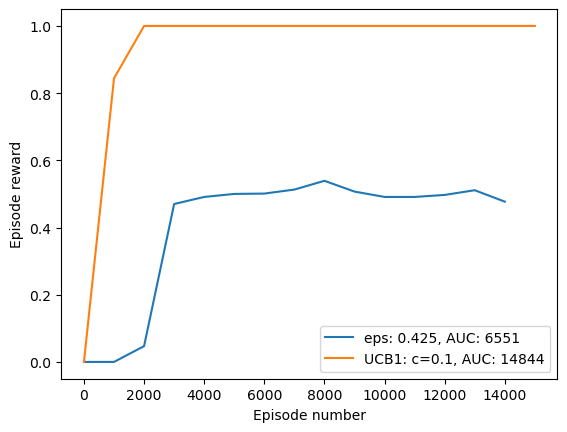

In [5]:
Q = np.zeros([env.observation_space.n, env.action_space.n])
n_s_a = np.zeros([env.observation_space.n, env.action_space.n])
num_episodes = 15000
c = .1
plot_labels.append(f"UCB1: c={c}")

for episode in range(num_episodes+1):
    state, info = env.reset()
    done = False
    results_list = []
    result_sum = 0.0
    while not done:
        if np.any(n_s_a[state] == 0):
            # first, try every action at least once
            action = np.random.choice(np.argwhere(n_s_a[state] == 0).flatten())
        else:
            # then, use upper bounds to choose actions
            R_s_a = Q[state, :]
            n_s_a_ = n_s_a[state]
            n_s = n_s_a_.sum()
            B_s_a = R_s_a + 2 * c * np.sqrt(2 * np.log(n_s) / n_s_a_)
            action = np.random.choice(np.argwhere(B_s_a==np.max(B_s_a)).flatten())
        new_state, reward, term, trunc, info = env.step(action)
        done = term or trunc
        results_list.append((state, action))
        result_sum += reward
        state = new_state

    for (state, action) in results_list:
        n_s_a[state, action] += 1.0
        alpha = 1.0 / n_s_a[state, action]
        Q[state, action] += alpha * (result_sum - Q[state, action])

    reward_list[experiment_id].append(result_sum)
    auc[experiment_id] += int(result_sum)

    if episode % 1000 == 0:
        plot_data[experiment_id].append([episode, np.array(reward_list[experiment_id]).mean(), np.array(reward_list[experiment_id]).std()])
        reward_list[experiment_id] = []

        for i in range(len(plot_data)):
            plt.plot([x[0] for x in plot_data[i]], [x[1] for x in plot_data[i]],
                     '-', label=plot_labels[i] + ', AUC: '+str(auc[i]))
        plt.xlabel('Episode number')
        plt.ylabel('Episode reward')
        plt.legend()
        disp.clear_output(wait=True)
        plt.show()

# advance to next experiment (so when we run the cell again we retain previous results)
experiment_id += 1
reward_list.append([])
plot_data.append([])

auc.append(0)